# SWB Computational Models

- Winning model from 2014 "A computational and neural model of momentary subjective well-being"
- Adapted to include counterfactual information 

Created: 05/04/2023 by Alie Fink

### Computational Models:
Standard GLMs:
1) RPE (CR+EV+RPE)
2) Counterfactual (CR+EV+CPE) *test tCPE vs dCPE
3) Counterfactual+RPE (CR+EV+RPE+CPE)
4) Regret (CR+EV+nCPE) *omit RPE if model 2 > model 3
5) Relief (CR+EV+pCPE) *omit RPE if model 2 > model 3
6) Regret/Relief (CR+EV+nCPE+pCPE) *omit RPE if model 2 > model 3
7) Full model (CR+EV+RPE+nCPE+pCPE)

Prospect Theory GLMs:

8)  Rutledge EV (CR+EV)
9)  PT (Util_s+Util_g) *validate this is better than Rutledge EV
10) RPE PT (Util_s+Util_g+RPE)
11) CPE PT (Util_s+Util_g+CPE) *test tCPE vs dCPE 
12) CPE+RPE PT (Util_s+Util_g+RPE+CPE) 
13) Regret PT (Util_s+Util_g+RPE+nCPE) *omit RPE if model 9 > model 8
14) Relief PT (Util_s+Util_g+RPE+pCPE) *omit RPE if model 9 > model 8
15) Regret/Relief PT (Util_s+Util_g+RPE+nCPE+pCPE) *omit RPE if model 9 > model 8


In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
import scipy
from scipy.optimize import least_squares
import sklearn
from sklearn.metrics import r2_score
import random


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/scripts/')
import SWB_modeling_utils

In [5]:
swb_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/'
subj_list = pd.read_excel(f'{swb_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0])
subj_ids = list(subj_list.PatientID)

## Standard GLMs

Step 1: Choose winning model from 1-4 (RPE+CPE or CPE only & tCPE vs dCPE)

1) RPE (CR+EV+RPE)
2) tCPE (CR+EV+tCPE) 
3) dCPE (CR+EV+dCPE) 
4) tCPE+RPE (CR+EV+RPE+tCPE)
5) dCPE+RPE  (CR+EV+RPE+dCPE)

Step 2: Choose winning model from 6-11

6) total Regret (CR+EV+tRegret) *omit RPE if model 2 > model 1
7) decision Regret (CR+EV+dRegret) *omit RPE if model 2 > model 1
8) total Relief (CR+EV+tRelief) *omit RPE if model 2 > model 1
9) decision Relief (CR+EV+dRelief) *omit RPE if model 2 > model 1
10) total Regret/Relief (CR+EV+tRegret+tRelief) *omit RPE if model 2 > model 1
11) decision Regret/Relief (CR+EV+dRegret+dRelief) *omit RPE if model 2 > model 1

In [6]:
model_input_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/data/model_input_data_06192023'
model_input = pd.read_csv(model_input_path)

In [7]:
model_input.columns

Index(['subj_id', 'round', 'rate', 'zscore_rate', 'cr(t-1)', 'cr(t-2)',
       'cr(t-3)', 'choice_ev(t-1)', 'choice_ev(t-2)', 'choice_ev(t-3)',
       'rpe(t-1)', 'rpe(t-2)', 'rpe(t-3)', 'totalcpe(t-1)', 'totalcpe(t-2)',
       'totalcpe(t-3)', 'decisioncpe(t-1)', 'decisioncpe(t-2)',
       'decisioncpe(t-3)', 'totalregret(t-1)', 'totalregret(t-2)',
       'totalregret(t-3)', 'decisionregret(t-1)', 'decisionregret(t-2)',
       'decisionregret(t-3)', 'totalrelief(t-1)', 'totalrelief(t-2)',
       'totalrelief(t-3)', 'decisionrelief(t-1)', 'decisionrelief(t-2)',
       'decisionrelief(t-3)'],
      dtype='object')

### Step 1: Choose winning model from 1-4 (RPE+CPE or CPE only & tCPE vs dCPE)
- Include RPE in CPE models?
- Is total CPE or decision CPE a better CPE metric (total = outcome - max possible, decision = outcome - max unchosen)

In [157]:
model1_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)"]
model2_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
model3_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","decisioncpe(t-1)","decisioncpe(t-2)","decisioncpe(t-3)"]
model4_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
model5_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","decisioncpe(t-1)","decisioncpe(t-2)","decisioncpe(t-3)"]


In [158]:
models_dict = {}
models_dict['rpe'] = model1_vars
models_dict['tcpe'] = model2_vars
models_dict['dcpe'] = model3_vars
models_dict['rpe+tcpe'] = model4_vars
models_dict['rpe+dcpe'] = model5_vars


In [159]:
#### run swb to find optimal parameters 
models_list = ['rpe','tcpe','dcpe','rpe+tcpe','rpe+dcpe']
lam_method = 'exp'

step1_results = {}

for model in models_list:

    reg_list = models_dict[model]
    n_regs = int(len(reg_list)/3)

    mood_est_df, optim_resid_df, optim_inits_df, param_fits_df, aic_dict,bic1_dict,bic2_dict, rsq_dict = \
    SWB_modeling_utils.run_swb(model_input, subj_ids, n_regs, reg_list,lam_method)
    

    step1_results[model] = {'mood_est': mood_est_df,
                            'optim_residuals':optim_resid_df,
                           'optim_inits': optim_inits_df,
                           'param_fits': param_fits_df,
                            'aics':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }



In [160]:
### use optimal parameters to run model 

models_list = ['rpe','tcpe','dcpe','rpe+tcpe','rpe+dcpe']
lam_method = 'exp'

step1_data = {}

for model in models_list:

    reg_list = models_dict[model]
    n_regs = int(len(reg_list)/3)
    params = step1_results[model]['param_fits']

    mood_est_df, resid_df, rss_dict, aic_dict, bic1_dict, bic2_dict, rsq_dict = \
    SWB_modeling_utils.fit_swb(model_input,subj_ids,params,n_regs,reg_list,lam_method)
    

    step1_data[model] = {'mood_est': mood_est_df,
                            'residuals':resid_df,
                           'rss': rss_dict,
                            'aic':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }


In [161]:
for ix,s in enumerate(subj_ids):
    best_bic = np.inf
    best_rsq = -np.inf
    best_model_bic = []
    best_model_rsq = []
    for model in models_list:
        bic = step1_data[model]['bics1'][s]
        rsq = step1_data[model]['rsqs'][s]
        if bic<best_bic:
            best_bic = bic 
            best_model_bic = model
        if rsq>best_rsq:
            best_rsq=rsq
            best_model_rsq = model
        
    print('best model bic for ',s,'is',best_model_bic,best_bic)
    print('best model rsq for ',s,'is',best_model_rsq,best_rsq)

best model bic for  DA8 is tcpe -87.26059124636848
best model rsq for  DA8 is tcpe -0.13666765257459224
best model bic for  DA9 is rpe -144.75492337883608
best model rsq for  DA9 is rpe -0.0578440849232682
best model bic for  DA10 is rpe -154.95114331751944
best model rsq for  DA10 is rpe+tcpe -0.04273040206655998
best model bic for  DA11 is rpe -234.0190725614674
best model rsq for  DA11 is rpe+tcpe 0.053892757431125426
best model bic for  DA023 is rpe -212.8242589134889
best model rsq for  DA023 is rpe+dcpe 0.03526149312757776
best model bic for  MS002 is tcpe -227.9463346803264
best model rsq for  MS002 is tcpe 0.04663391477736345
best model bic for  MS003 is rpe -233.4691317737662
best model rsq for  MS003 is rpe 0.05319280838506457
best model bic for  MS016 is rpe -262.3095998493814
best model rsq for  MS016 is rpe 0.08671783244190101
best model bic for  MS017 is rpe -152.03161747631245
best model rsq for  MS017 is rpe -0.04826570304774802
best model bic for  MS019 is rpe+tcpe -20

In [162]:
print('model 1 bic1 mean',np.mean(np.array(list(step1_data['rpe']['bics1'].values()))))
print('model 2 bic1 mean',np.mean(np.array(list(step1_data['tcpe']['bics1'].values()))))
print('model 3 bic1 mean',np.mean(np.array(list(step1_data['dcpe']['bics1'].values()))))
print('model 4 bic1 mean',np.mean(np.array(list(step1_data['rpe+tcpe']['bics1'].values()))))
print('model 5 bic1 mean',np.mean(np.array(list(step1_data['rpe+dcpe']['bics1'].values()))))

model 1 bic1 mean -146.1656300424874
model 2 bic1 mean -164.99193766163947
model 3 bic1 mean -133.0735721922247
model 4 bic1 mean -122.60740798241996
model 5 bic1 mean -113.86254893676015


In [163]:
print('model 1 bic1 sum',np.sum(np.array(list(step1_data['rpe']['bics1'].values()))))
print('model 2 bic1 sum',np.sum(np.array(list(step1_data['tcpe']['bics1'].values()))))
print('model 3 bic1 sum',np.sum(np.array(list(step1_data['dcpe']['bics1'].values()))))
print('model 4 bic1 sum',np.sum(np.array(list(step1_data['rpe+tcpe']['bics1'].values()))))
print('model 5 bic1 sum',np.sum(np.array(list(step1_data['rpe+dcpe']['bics1'].values()))))

model 1 bic1 sum -2338.6500806797985
model 2 bic1 sum -2639.8710025862315
model 3 bic1 sum -2129.1771550755952
model 4 bic1 sum -1961.7185277187193
model 5 bic1 sum -1821.8007829881624


In [164]:
print('model 1 bic2 mean',np.mean(np.array(list(step1_data['rpe']['bics2'].values()))))
print('model 2 bic2 mean',np.mean(np.array(list(step1_data['tcpe']['bics2'].values()))))
print('model 3 bic2 mean',np.mean(np.array(list(step1_data['dcpe']['bics2'].values()))))
print('model 4 bic2 mean',np.mean(np.array(list(step1_data['rpe+tcpe']['bics2'].values()))))
print('model 5 bic2 mean',np.mean(np.array(list(step1_data['rpe+dcpe']['bics2'].values()))))

model 1 bic2 mean 33.8720303600417
model 2 bic2 mean 33.91909612908958
model 3 bic2 mean 33.839300215416046
model 4 bic2 mean 40.51445806187863
model 5 bic2 mean 40.492595914264484


In [165]:
print('model 1 bic2 sum',np.sum(np.array(list(step1_data['rpe']['bics2'].values()))))
print('model 2 bic2 sum',np.sum(np.array(list(step1_data['tcpe']['bics2'].values()))))
print('model 3 bic2 sum',np.sum(np.array(list(step1_data['dcpe']['bics2'].values()))))
print('model 4 bic2 sum',np.sum(np.array(list(step1_data['rpe+tcpe']['bics2'].values()))))
print('model 5 bic2 sum',np.sum(np.array(list(step1_data['rpe+dcpe']['bics2'].values()))))

model 1 bic2 sum 541.9524857606672
model 2 bic2 sum 542.7055380654333
model 3 bic2 sum 541.4288034466567
model 4 bic2 sum 648.231328990058
model 5 bic2 sum 647.8815346282317


In [166]:
print('model 1 aic mean',np.mean(np.array(list(step1_data['rpe']['aic'].values()))))
print('model 2 aic mean',np.mean(np.array(list(step1_data['tcpe']['aic'].values()))))
print('model 3 aic mean',np.mean(np.array(list(step1_data['dcpe']['aic'].values()))))
print('model 4 aic mean',np.mean(np.array(list(step1_data['rpe+tcpe']['aic'].values()))))
print('model 5 aic mean',np.mean(np.array(list(step1_data['rpe+dcpe']['aic'].values()))))


model 1 aic mean -169.58868868082703
model 2 aic mean -188.4149962999791
model 3 aic mean -156.49663083056433
model 4 aic mean -150.71507834842754
model 5 aic mean -141.9702193027677


In [167]:
print('model 1 aic sum',np.sum(np.array(list(step1_data['rpe']['aic'].values()))))
print('model 2 aic sum',np.sum(np.array(list(step1_data['tcpe']['aic'].values()))))
print('model 3 aic sum',np.sum(np.array(list(step1_data['dcpe']['aic'].values()))))
print('model 4 aic sum',np.sum(np.array(list(step1_data['rpe+tcpe']['aic'].values()))))
print('model 5 aic sum',np.sum(np.array(list(step1_data['rpe+dcpe']['aic'].values()))))


model 1 aic sum -2713.4190188932325
model 2 aic sum -3014.6399407996655
model 3 aic sum -2503.9460932890292
model 4 aic sum -2411.4412535748406
model 5 aic sum -2271.5235088442832


In [168]:
print('model 1 rsq mean',np.mean(np.array(list(step1_data['rpe']['rsqs'].values()))))
print('model 2 rsq mean',np.mean(np.array(list(step1_data['tcpe']['rsqs'].values()))))
print('model 3 rsq mean',np.mean(np.array(list(step1_data['dcpe']['rsqs'].values()))))
print('model 4 rsq mean',np.mean(np.array(list(step1_data['rpe+tcpe']['rsqs'].values()))))
print('model 5 rsq mean',np.mean(np.array(list(step1_data['rpe+dcpe']['rsqs'].values()))))


model 1 rsq mean -0.07639519134739836
model 2 rsq mean -0.0332640716428621
model 3 rsq mean -0.07843618780718267
model 4 rsq mean -0.09890772242099947
model 5 rsq mean -0.11510367891518661


In [169]:
print('model 1 rsq sum',np.sum(np.array(list(step1_data['rpe']['rsqs'].values()))))
print('model 2 rsq sum',np.sum(np.array(list(step1_data['tcpe']['rsqs'].values()))))
print('model 3 rsq sum',np.sum(np.array(list(step1_data['dcpe']['rsqs'].values()))))
print('model 4 rsq sum',np.sum(np.array(list(step1_data['rpe+tcpe']['rsqs'].values()))))
print('model 5 rsq sum',np.sum(np.array(list(step1_data['rpe+dcpe']['rsqs'].values()))))

model 1 rsq sum -1.2223230615583738
model 2 rsq sum -0.5322251462857936
model 3 rsq sum -1.2549790049149228
model 4 rsq sum -1.5825235587359916
model 5 rsq sum -1.8416588626429857


### Results of step 1: 
- adding RPE adds explanatory power to the model but worsens BIC
- total CPE is better

### Step 2: Choose winning regret/relief model
- total vs decision regret/relief
- regret or relief?

In [170]:
model6_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)"]
model7_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","decisionregret(t-1)","decisionregret(t-2)","decisionregret(t-3)"]
model8_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
model9_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","decisionrelief(t-1)","decisionrelief(t-2)","decisionrelief(t-3)"]
model10_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
model11_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","decisionregret(t-1)","decisionregret(t-2)","decisionregret(t-3)","decisionrelief(t-1)","decisionrelief(t-2)","decisionrelief(t-3)"]

In [171]:
models_dict['treg'] = model6_vars
models_dict['dreg'] = model7_vars
models_dict['trel'] = model8_vars
models_dict['drel'] = model9_vars
models_dict['treg/rel'] = model10_vars
models_dict['dreg/rel'] = model11_vars


In [172]:
models_list2 = ['treg','dreg','trel','drel','treg/rel','dreg/rel']
lam_method = 'exp'

step2_results = {}

for model in models_list2:

    reg_list = models_dict[model]
    n_regs = int(len(reg_list)/3)

    mood_est_df, optim_resid_df, optim_inits_df, param_fits_df, aic_dict,bic1_dict,bic2_dict, rsq_dict = \
    SWB_modeling_utils.run_swb(model_input, subj_ids, n_regs, reg_list,lam_method)
    

    step2_results[model] = {'mood_est': mood_est_df,
                            'optim_residuals':optim_resid_df,
                           'optim_inits': optim_inits_df,
                           'param_fits': param_fits_df,
                            'aics':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }



In [173]:
### use optimal parameters to run model 

models_list2 = ['treg','dreg','trel','drel','treg/rel','dreg/rel']
lam_method = 'exp'

step2_data = {}

for model in models_list2:

    reg_list = models_dict[model]
    n_regs = int(len(reg_list)/3)
    params = step2_results[model]['param_fits']

    mood_est_df, resid_df, rss_dict, aic_dict, bic1_dict, bic2_dict, rsq_dict = \
    SWB_modeling_utils.fit_swb(model_input,subj_ids,params,n_regs,reg_list,lam_method)
    

    step2_data[model] = {'mood_est': mood_est_df,
                            'residuals':resid_df,
                           'rss': rss_dict,
                            'aic':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }


In [174]:
for ix,s in enumerate(subj_ids):
    best_bic = np.inf
    best_rsq = -np.inf
    best_model_bic = []
    best_model_rsq = []
    for model in models_list2:
        bic = step2_data[model]['bics1'][s]
        rsq = step2_data[model]['rsqs'][s]
        if bic<best_bic:
            best_bic = bic 
            best_model_bic = model
        if rsq>best_rsq:
            best_rsq=rsq
            best_model_rsq = model
        
    print('best model bic for ',s,'is',best_model_bic,best_bic)
    print('best model rsq for ',s,'is',best_model_rsq,best_rsq)

best model bic for  DA8 is treg -52.99580099315201
best model rsq for  DA8 is treg/rel -0.1802226521838588
best model bic for  DA9 is treg -169.10497167343092
best model rsq for  DA9 is treg -0.026130974911873217
best model bic for  DA10 is treg/rel -149.3723350029611
best model rsq for  DA10 is treg/rel -0.04300443236376039
best model bic for  DA11 is treg -239.13325144876046
best model rsq for  DA11 is treg 0.05987266982472661
best model bic for  DA023 is trel -228.04571460788094
best model rsq for  DA023 is trel 0.04675233923718136
best model bic for  MS002 is treg/rel -253.68395001237687
best model rsq for  MS002 is treg/rel 0.0844992476920603
best model bic for  MS003 is treg -236.96156503157204
best model rsq for  MS003 is treg/rel 0.06203036883677371
best model bic for  MS016 is treg/rel -252.3673517977962
best model rsq for  MS016 is treg/rel 0.08299132388136587
best model bic for  MS017 is treg/rel -165.5136480248748
best model rsq for  MS017 is treg/rel -0.022170987319211077


In [175]:
print('model 6 bic1 mean',np.mean(np.array(list(step2_data['treg']['bics1'].values()))))
print('model 7 bic1 mean',np.mean(np.array(list(step2_data['dreg']['bics1'].values()))))
print('model 8 bic1 mean',np.mean(np.array(list(step2_data['trel']['bics1'].values()))))
print('model 9 bic1 mean',np.mean(np.array(list(step2_data['drel']['bics1'].values()))))
print('model 10 bic1 mean',np.mean(np.array(list(step2_data['treg/rel']['bics1'].values()))))
print('model 11 bic1 mean',np.mean(np.array(list(step2_data['dreg/rel']['bics1'].values()))))

model 6 bic1 mean -167.39192240233433
model 7 bic1 mean -144.99023914114258
model 8 bic1 mean -135.4764494093044
model 9 bic1 mean -131.85426724005782
model 10 bic1 mean -157.03947528591175
model 11 bic1 mean -137.93134204427884


In [176]:
print('model 6 bic1 sum',np.sum(np.array(list(step2_data['treg']['bics1'].values()))))
print('model 7 bic1 sum',np.sum(np.array(list(step2_data['dreg']['bics1'].values()))))
print('model 8 bic1 sum',np.sum(np.array(list(step2_data['trel']['bics1'].values()))))
print('model 9 bic1 sum',np.sum(np.array(list(step2_data['drel']['bics1'].values()))))
print('model 10 bic1 sum',np.sum(np.array(list(step2_data['treg/rel']['bics1'].values()))))
print('model 11 bic1 sum',np.sum(np.array(list(step2_data['dreg/rel']['bics1'].values()))))

model 6 bic1 sum -2678.2707584373493
model 7 bic1 sum -2319.8438262582813
model 8 bic1 sum -2167.6231905488703
model 9 bic1 sum -2109.668275840925
model 10 bic1 sum -2512.631604574588
model 11 bic1 sum -2206.9014727084614


In [177]:
print('model 6 bic2 mean',np.mean(np.array(list(step2_data['treg']['bics2'].values()))))
print('model 7 bic2 mean',np.mean(np.array(list(step2_data['dreg']['bics2'].values()))))
print('model 8 bic2 mean',np.mean(np.array(list(step2_data['trel']['bics2'].values()))))
print('model 9 bic2 mean',np.mean(np.array(list(step2_data['drel']['bics2'].values()))))
print('model 10 bic2 mean',np.mean(np.array(list(step2_data['treg/rel']['bics2'].values()))))
print('model 11 bic2 mean',np.mean(np.array(list(step2_data['dreg/rel']['bics2'].values()))))

model 6 bic2 mean 33.92509609094132
model 7 bic2 mean 33.86909188278834
model 8 bic2 mean 33.845307408458744
model 9 bic2 mean 33.83625195303563
model 10 bic2 mean 40.60053823013736
model 11 bic2 mean 40.55276789703328


In [178]:
print('model 6 bic2 sum',np.sum(np.array(list(step2_data['treg']['bics2'].values()))))
print('model 7 bic2 sum',np.sum(np.array(list(step2_data['dreg']['bics2'].values()))))
print('model 8 bic2 sum',np.sum(np.array(list(step2_data['trel']['bics2'].values()))))
print('model 9 bic2 sum',np.sum(np.array(list(step2_data['drel']['bics2'].values()))))
print('model 10 bic2 sum',np.sum(np.array(list(step2_data['treg/rel']['bics2'].values()))))
print('model 11 bic2 sum',np.sum(np.array(list(step2_data['dreg/rel']['bics2'].values()))))

model 6 bic2 sum 542.8015374550611
model 7 bic2 sum 541.9054701246134
model 8 bic2 sum 541.5249185353399
model 9 bic2 sum 541.38003124857
model 10 bic2 sum 649.6086116821978
model 11 bic2 sum 648.8442863525324


In [179]:
print('model 6 aic mean',np.mean(np.array(list(step2_data['treg']['aic'].values()))))
print('model 7 aic mean',np.mean(np.array(list(step2_data['dreg']['aic'].values()))))
print('model 8 aic mean',np.mean(np.array(list(step2_data['trel']['aic'].values()))))
print('model 9 aic mean',np.mean(np.array(list(step2_data['drel']['aic'].values()))))
print('model 10 aic mean',np.mean(np.array(list(step2_data['treg/rel']['aic'].values()))))
print('model 11 aic mean',np.mean(np.array(list(step2_data['dreg/rel']['aic'].values()))))


model 6 aic mean -190.81498104067396
model 7 aic mean -168.4132977794822
model 8 aic mean -158.89950804764402
model 9 aic mean -155.27732587839745
model 10 aic mean -185.1471456519193
model 11 aic mean -166.03901241028638


In [180]:
print('model 6 aic sum',np.sum(np.array(list(step2_data['treg']['aic'].values()))))
print('model 7 aic sum',np.sum(np.array(list(step2_data['dreg']['aic'].values()))))
print('model 8 aic sum',np.sum(np.array(list(step2_data['trel']['aic'].values()))))
print('model 9 aic sum',np.sum(np.array(list(step2_data['drel']['aic'].values()))))
print('model 10 aic sum',np.sum(np.array(list(step2_data['treg/rel']['aic'].values()))))
print('model 11 aic sum',np.sum(np.array(list(step2_data['dreg/rel']['aic'].values()))))


model 6 aic sum -3053.0396966507833
model 7 aic sum -2694.6127644717153
model 8 aic sum -2542.3921287623043
model 9 aic sum -2484.437214054359
model 10 aic sum -2962.3543304307086
model 11 aic sum -2656.624198564582


In [181]:
print('model 6 rsq mean',np.mean(np.array(list(step2_data['treg']['rsqs'].values()))))
print('model 7 rsq mean',np.mean(np.array(list(step2_data['dreg']['rsqs'].values()))))
print('model 8 rsq mean',np.mean(np.array(list(step2_data['trel']['rsqs'].values()))))
print('model 9 rsq mean',np.mean(np.array(list(step2_data['drel']['rsqs'].values()))))
print('model 10 rsq mean',np.mean(np.array(list(step2_data['treg/rel']['rsqs'].values()))))
print('model 11 rsq mean',np.mean(np.array(list(step2_data['dreg/rel']['rsqs'].values()))))


model 6 rsq mean -0.032098472790861976
model 7 rsq mean -0.061183638487067274
model 8 rsq mean -0.07824226986996882
model 9 rsq mean -0.08317343669447821
model 10 rsq mean -0.0389399937523847
model 11 rsq mean -0.06167668243920866


In [182]:
print('model 6 rsq sum',np.sum(np.array(list(step2_data['treg']['rsqs'].values()))))
print('model 7 rsq sum',np.sum(np.array(list(step2_data['dreg']['rsqs'].values()))))
print('model 8 rsq sum',np.sum(np.array(list(step2_data['trel']['rsqs'].values()))))
print('model 9 rsq sum',np.sum(np.array(list(step2_data['drel']['rsqs'].values()))))
print('model 10 rsq sum',np.sum(np.array(list(step2_data['treg/rel']['rsqs'].values()))))
print('model 11 rsq sum',np.sum(np.array(list(step2_data['dreg/rel']['rsqs'].values()))))

model 6 rsq sum -0.5135755646537916
model 7 rsq sum -0.9789382157930764
model 8 rsq sum -1.2518763179195012
model 9 rsq sum -1.3307749871116514
model 10 rsq sum -0.6230399000381552
model 11 rsq sum -0.9868269190273385


### Results of step 2
- best fit is total regret (consistent with step 1 results that total calculation is best)
- regret is overall a better fit than relief
- adding total regret & total relief together out performs relief alone 

### Step 3: Summary of basic GLMs
Finalize - 

1) RPE (CR+EV+RPE)
2) Counterfactual (CR+EV+tCPE) 
3) Counterfactual+RPE (CR+EV+RPE+tCPE)
4) Regret (CR+EV+regret) 
5) Relief (CR+EV+relief)
6) Regret/Relief (CR+EV+regret+relief)
7) Full model (CR+EV+RPE+regret+relief)


In [8]:
glm1_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)"]
glm2_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
glm3_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
glm4_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)"]
glm5_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
glm6_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
glm7_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]


In [9]:
glms_dict = {}
glms_dict['RPE'] = glm1_vars
glms_dict['CPE'] = glm2_vars
glms_dict['CPE+RPE'] = glm3_vars
glms_dict['Regret'] = glm4_vars
glms_dict['Relief'] = glm5_vars
glms_dict['Regret+Relief'] = glm6_vars
glms_dict['Full'] = glm7_vars

In [10]:
glms_list = ['RPE','CPE','CPE+RPE','Regret','Relief','Regret+Relief','Full']
lam_method = 'exp'
glm_results = {}

for model in glms_list:

    reg_list = glms_dict[model]
    n_regs = int(len(reg_list)/3)

    mood_est_df, optim_resid_df, optim_inits_df, param_fits_df, aic_dict,bic1_dict,bic2_dict, rsq_dict = \
    SWB_modeling_utils.run_swb(model_input, subj_ids, n_regs, reg_list,lam_method)
    

    glm_results[model] = {'mood_est': mood_est_df,
                            'optim_residuals':optim_resid_df,
                           'optim_inits': optim_inits_df,
                           'param_fits': param_fits_df,
                            'aics':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }


In [11]:
### use optimal parameters to run model 

glms_list = ['RPE','CPE','CPE+RPE','Regret','Relief','Regret+Relief','Full']
lam_method = 'exp'
glm_data = {}

for model in glms_list:

    reg_list = glms_dict[model]
    n_regs = int(len(reg_list)/3)
    params = glm_results[model]['param_fits']

    mood_est_df, resid_df, rss_dict, aic_dict, bic1_dict, bic2_dict, rsq_dict = \
    SWB_modeling_utils.fit_swb(model_input,subj_ids,params,n_regs,reg_list,lam_method)
    

    glm_data[model] = {'mood_est': mood_est_df,
                            'residuals':resid_df,
                           'rss': rss_dict,
                            'aic':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }


In [12]:
for ix,s in enumerate(subj_ids):
    best_bic = np.inf
    best_rsq = -np.inf
    best_model_bic = []
    best_model_rsq = []
    for model in glms_list:
        bic = glm_data[model]['bics1'][s]
        rsq = glm_data[model]['rsqs'][s]
        if bic<best_bic:
            best_bic = bic 
            best_model_bic = model
        if rsq>best_rsq:
            best_rsq=rsq
            best_model_rsq = model
        
    print('best model bic for ',s,'is',best_model_bic,best_bic)
    print('best model rsq for ',s,'is',best_model_rsq,best_rsq)

best model bic for  DA8 is CPE -87.26042072007704
best model rsq for  DA8 is CPE -0.13666789486426656
best model bic for  DA9 is Regret -169.1054552834208
best model rsq for  DA9 is Regret -0.02613035460307178
best model bic for  DA10 is RPE -154.94718974392111
best model rsq for  DA10 is Full -0.03826046312882392
best model bic for  DA11 is Regret -239.13325059063345
best model rsq for  DA11 is Full 0.06126898717475393
best model bic for  DA023 is Relief -228.0457145127653
best model rsq for  DA023 is Relief 0.04675233912384402
best model bic for  MS002 is Regret+Relief -253.68442646502993
best model rsq for  MS002 is Regret+Relief 0.08449979293284848
best model bic for  MS003 is Regret -236.96156477579893
best model rsq for  MS003 is Regret+Relief 0.062030368527653756
best model bic for  MS016 is RPE -262.3095300406799
best model rsq for  MS016 is Full 0.08750216003292688
best model bic for  MS017 is Regret+Relief -165.51354797388265
best model rsq for  MS017 is Regret+Relief -0.0221

In [13]:
print('glm1 bic1 mean',np.mean(np.array(list(glm_data['RPE']['bics1'].values()))))
print('glm2 bic1 mean',np.mean(np.array(list(glm_data['CPE']['bics1'].values()))))
print('glm3 bic1 mean',np.mean(np.array(list(glm_data['CPE+RPE']['bics1'].values()))))
print('glm4 bic1 mean',np.mean(np.array(list(glm_data['Regret']['bics1'].values()))))
print('glm5 bic1 mean',np.mean(np.array(list(glm_data['Relief']['bics1'].values()))))
print('glm6 bic1 mean',np.mean(np.array(list(glm_data['Regret+Relief']['bics1'].values()))))
print('glm7 bic1 mean',np.mean(np.array(list(glm_data['Full']['bics1'].values()))))

glm1 bic1 mean -146.16409751255213
glm2 bic1 mean -164.9923162074839
glm3 bic1 mean -122.60833910497001
glm4 bic1 mean -176.35355952744814
glm5 bic1 mean -135.47923547037408
glm6 bic1 mean -157.0392042949149
glm7 bic1 mean -108.62281529243498


In [14]:
print('glm1 bic1 sum',np.sum(np.array(list(glm_data['RPE']['bics1'].values()))))
print('glm2 bic1 sum',np.sum(np.array(list(glm_data['CPE']['bics1'].values()))))
print('glm3 bic1 sum',np.sum(np.array(list(glm_data['CPE+RPE']['bics1'].values()))))
print('glm4 bic1 sum',np.sum(np.array(list(glm_data['Regret']['bics1'].values()))))
print('glm5 bic1 sum',np.sum(np.array(list(glm_data['Relief']['bics1'].values()))))
print('glm6 bic1 sum',np.sum(np.array(list(glm_data['Regret+Relief']['bics1'].values()))))
print('glm7 bic1 sum',np.sum(np.array(list(glm_data['Full']['bics1'].values()))))

glm1 bic1 sum -2338.625560200834
glm2 bic1 sum -2639.8770593197423
glm3 bic1 sum -1961.7334256795202
glm4 bic1 sum -2821.6569524391703
glm5 bic1 sum -2167.6677675259853
glm6 bic1 sum -2512.6272687186383
glm7 bic1 sum -1737.9650446789597


In [15]:
print('glm1 bic2 mean',np.mean(np.array(list(glm_data['RPE']['bics2'].values()))))
print('glm2 bic2 mean',np.mean(np.array(list(glm_data['CPE']['bics2'].values()))))
print('glm3 bic2 mean',np.mean(np.array(list(glm_data['CPE+RPE']['bics2'].values()))))
print('glm4 bic2 mean',np.mean(np.array(list(glm_data['Regret']['bics2'].values()))))
print('glm5 bic2 mean',np.mean(np.array(list(glm_data['Relief']['bics2'].values()))))
print('glm6 bic2 mean',np.mean(np.array(list(glm_data['Regret+Relief']['bics2'].values()))))
print('glm7 bic2 mean',np.mean(np.array(list(glm_data['Full']['bics2'].values()))))

glm1 bic2 mean 33.87202652871686
glm2 bic2 mean 33.91909707545419
glm3 bic2 mean 40.514460389685
glm4 bic2 mean 33.9475001837541
glm5 bic2 mean 33.845314373611416
glm6 bic2 mean 40.600537552659866
glm7 bic2 mean 47.18081983714077


In [16]:
print('glm1 bic2 sum',np.sum(np.array(list(glm_data['RPE']['bics2'].values()))))
print('glm2 bic2 sum',np.sum(np.array(list(glm_data['CPE']['bics2'].values()))))
print('glm3 bic2 sum',np.sum(np.array(list(glm_data['CPE+RPE']['bics2'].values()))))
print('glm4 bic2 sum',np.sum(np.array(list(glm_data['Regret']['bics2'].values()))))
print('glm5 bic2 sum',np.sum(np.array(list(glm_data['Relief']['bics2'].values()))))
print('glm6 bic2 sum',np.sum(np.array(list(glm_data['Regret+Relief']['bics2'].values()))))
print('glm7 bic2 sum',np.sum(np.array(list(glm_data['Full']['bics2'].values()))))

glm1 bic2 sum 541.9524244594697
glm2 bic2 sum 542.705553207267
glm3 bic2 sum 648.23136623496
glm4 bic2 sum 543.1600029400656
glm5 bic2 sum 541.5250299777827
glm6 bic2 sum 649.6086008425578
glm7 bic2 sum 754.8931173942523


In [17]:
print('glm1 aic mean',np.mean(np.array(list(glm_data['RPE']['aic'].values()))))
print('glm2 aic mean',np.mean(np.array(list(glm_data['CPE']['aic'].values()))))
print('glm3 aic mean',np.mean(np.array(list(glm_data['CPE+RPE']['aic'].values()))))
print('glm4 aic mean',np.mean(np.array(list(glm_data['Regret']['aic'].values()))))
print('glm5 aic mean',np.mean(np.array(list(glm_data['Relief']['aic'].values()))))
print('glm6 aic mean',np.mean(np.array(list(glm_data['Regret+Relief']['aic'].values()))))
print('glm7 aic mean',np.mean(np.array(list(glm_data['Full']['aic'].values()))))


glm1 aic mean -169.58715615089176
glm2 aic mean -188.41537484582352
glm3 aic mean -150.71600947097758
glm4 aic mean -199.7766181657878
glm5 aic mean -158.9022941087137
glm6 aic mean -185.1468746609225
glm7 aic mean -141.41509738611046


In [18]:
print('glm1 aic sum',np.sum(np.array(list(glm_data['RPE']['aic'].values()))))
print('glm2 aic sum',np.sum(np.array(list(glm_data['CPE']['aic'].values()))))
print('glm3 aic sum',np.sum(np.array(list(glm_data['CPE+RPE']['aic'].values()))))
print('glm4 aic sum',np.sum(np.array(list(glm_data['Regret']['aic'].values()))))
print('glm5 aic sum',np.sum(np.array(list(glm_data['Relief']['aic'].values()))))
print('glm6 aic sum',np.sum(np.array(list(glm_data['Regret+Relief']['aic'].values()))))
print('glm7 aic sum',np.sum(np.array(list(glm_data['Full']['aic'].values()))))


glm1 aic sum -2713.394498414268
glm2 aic sum -3014.6459975331763
glm3 aic sum -2411.4561515356413
glm4 aic sum -3196.4258906526047
glm5 aic sum -2542.4367057394193
glm6 aic sum -2962.34999457476
glm7 aic sum -2262.6415581777674


In [194]:
import pickle 
save_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/data/glm_data/'

# create a binary pickle file 
f = open(f'{save_path}/glm_data_06192023.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(glm_data,f)
# # close file
f.close()

# create a binary pickle file 
f = open(f'{save_path}/step1_data_06192023.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(step1_data,f)
# # close file
f.close()

# create a binary pickle file 
f = open(f'{save_path}/step2_data_06192023.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(step2_data,f)
# # close file
f.close()

In [195]:
import pickle 
save_path = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/swb_computational_modeling/swb_behav_models/data/glm_data/'

# create a binary pickle file 
f = open(f'{save_path}/glm_optim_results_06192023.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(glm_results,f)
# # close file
f.close()

# create a binary pickle file 
f = open(f'{save_path}/step1_optim_results_06192023.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(step1_results,f)
# # close file
f.close()

# create a binary pickle file 
f = open(f'{save_path}/step2_optim_results_06192023.pkl',"wb")
# # write the python object (dict) to pickle file
pickle.dump(step2_results,f)
# # close file
f.close()

## Test Lambda Parameter

In [25]:
glm1_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)"]
glm2_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
glm3_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
glm4_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)"]
glm5_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
glm6_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]
glm7_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalregret(t-1)","totalregret(t-2)","totalregret(t-3)","totalrelief(t-1)","totalrelief(t-2)","totalrelief(t-3)"]


In [144]:
lam_test_results = {}

lam_methods = ['exp','linear','none']

for lam in lam_methods: 
    reg_list = glm4_vars #test multiple here 
    n_regs = int(len(reg_list)/3)
    mood_est_df, optim_resid_df, optim_inits_df, param_fits_df, aic_dict,bic1_dict,bic2_dict, rsq_dict = \
    SWB_modeling_utils.run_swb(model_input, subj_ids, n_regs, reg_list,lam_method=lam)
    
    lam_test_results[lam] = {'mood_est': mood_est_df,
                            'optim_residuals':optim_resid_df,
                           'optim_inits': optim_inits_df,
                           'param_fits': param_fits_df,
                            'aics':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }
    
    
    



In [145]:
### use optimal parameters to run model 

lam_methods = ['exp','linear','none']
lam_test_data = {}

for lam in lam_methods: 

    reg_list = glm4_vars #test multiple here 
    n_regs = int(len(reg_list)/3)
    params = lam_test_results[lam]['param_fits']

    mood_est_df, resid_df, rss_dict, aic_dict, bic1_dict, bic2_dict, rsq_dict = \
    SWB_modeling_utils.fit_swb(model_input,subj_ids,params,n_regs,reg_list,lam_method=lam)
    

    lam_test_data[lam] = {'mood_est': mood_est_df,
                            'residuals':resid_df,
                           'rss': rss_dict,
                            'aic':aic_dict,
                           'bics1': bic1_dict,
                            'bics2': bic2_dict,
                           'rsqs': rsq_dict
                           }


In [146]:
for ix,s in enumerate(subj_ids):
    best_bic = np.inf
    best_rsq = -np.inf
    best_model_bic = []
    best_model_rsq = []
    for lam in lam_methods: 
        bic = lam_test_data[lam]['bics1'][s]
        rsq = lam_test_data[lam]['rsqs'][s]
        if bic<best_bic:
            best_bic = bic 
            best_model_bic = lam
        if rsq>best_rsq:
            best_rsq=rsq
            best_model_rsq = lam
        
    print('best model bic for ',s,'is',best_model_bic,best_bic)
    print('best model rsq for ',s,'is',best_model_rsq,best_rsq)

best model bic for  DA8 is linear -52.990532698392634
best model rsq for  DA8 is linear -0.18641771467165458
best model bic for  DA9 is exp -169.1057155513187
best model rsq for  DA9 is exp -0.026130020767139994
best model bic for  DA10 is none -170.80790238701806
best model rsq for  DA10 is none -0.02394901062785504
best model bic for  DA11 is exp -239.13324967282
best model rsq for  DA11 is exp 0.059872667737713825
best model bic for  DA023 is linear -216.64330497607267
best model rsq for  DA023 is linear 0.033068401844241646
best model bic for  MS002 is linear -252.78383218185854
best model rsq for  MS002 is linear 0.07577818920375634
best model bic for  MS003 is exp -236.96156502121693
best model rsq for  MS003 is exp 0.05731712553965829
best model bic for  MS016 is linear -246.24194847819018
best model rsq for  MS016 is linear 0.06818951434502407
best model bic for  MS017 is linear -157.59531595410255
best model rsq for  MS017 is linear -0.04100070213091489
best model bic for  MS0

In [147]:
print('exp bic1 mean',np.mean(np.array(list(lam_test_data['exp']['bics1'].values()))))
print('linear bic1 mean',np.mean(np.array(list(lam_test_data['linear']['bics1'].values()))))
print('none bic1 mean',np.mean(np.array(list(lam_test_data['none']['bics1'].values()))))


exp bic1 mean -169.66984217206902
linear bic1 mean -170.51662995145438
none bic1 mean -160.14758923173622


In [148]:
print('exp bic2 mean',np.mean(np.array(list(lam_test_data['exp']['bics2'].values()))))
print('linear bic2 mean',np.mean(np.array(list(lam_test_data['linear']['bics2'].values()))))
print('none bic2 mean',np.mean(np.array(list(lam_test_data['none']['bics2'].values()))))


exp bic2 mean 33.93079089036566
linear bic2 mean 33.932907859814115
none bic2 mean 33.90698525801483


In [149]:
print('exp aic mean',np.mean(np.array(list(lam_test_data['exp']['aic'].values()))))
print('linear aic mean',np.mean(np.array(list(lam_test_data['linear']['aic'].values()))))
print('none aic mean',np.mean(np.array(list(lam_test_data['none']['aic'].values()))))


exp aic mean -193.09290081040865
linear aic mean -193.939688589794
none aic mean -183.57064787007585


In [150]:
print('exp rsq mean',np.mean(np.array(list(lam_test_data['exp']['rsqs'].values()))))
print('linear rsq mean',np.mean(np.array(list(lam_test_data['linear']['rsqs'].values()))))
print('none rsq mean',np.mean(np.array(list(lam_test_data['none']['rsqs'].values()))))

exp rsq mean -0.02919101408522419
linear rsq mean -0.028201229303093926
none rsq mean -0.0412337430961645


Best fitting lambda for regret model (glm4) is exponential lambda - will keep exponential lambda for now


RPE (glm1) best fitting lambda is none
CPE (glm2) best fitting lambda is tie between exponential and linear
RPE/CPE (glm3) best fitting lambda is none
Regret (glm4) best fitting lambda is exponential (close to linear)
Relief (glm5) best fitting lambda is none
Reg/Rel (glm6) best fitting lambda is tie between exponential and linear
Full (glm7) best fitting lambda is none 

## BDI Comparison

In [19]:
bdi_list = pd.read_excel(f'{swb_dir}SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.BDI)

In [20]:
bdi_list

[13, 32, 11, 41, 14, 14, 8, 10, 26, 12, 10, 7, 11, 16, 32, 19]

In [21]:
list(zip(subj_ids,bdi_list))

[('DA8', 13),
 ('DA9', 32),
 ('DA10', 11),
 ('DA11', 41),
 ('DA023', 14),
 ('MS002', 14),
 ('MS003', 8),
 ('MS016', 10),
 ('MS017', 26),
 ('MS019', 12),
 ('MS022', 10),
 ('MS025', 7),
 ('MS026', 11),
 ('MS027', 16),
 ('MS029', 32),
 ('MS030', 19)]

In [22]:
dep_subj = []
nodep_subj = []

for s,b in list(zip(subj_ids,bdi_list)):
    if b > 20:
        dep_subj.append(s)
    else:
        nodep_subj.append(s)
        

In [23]:
cpe_fits = glm_results['CPE']['param_fits'] #CR/EV/CPE
cpe_rpe_fits = glm_results['CPE+RPE']['param_fits'] #CR/EV/RPE/CPE
regret_fits = glm_results['Regret']['param_fits'] #CR/EV/Reg
relief_fits = glm_results['Relief']['param_fits'] #CR/EV/Rel
full_fits = glm_results['Full']['param_fits'] #CR/EV/RPE/Reg/Rel
#2 = 'CPE', 3 = 'CPE+RPE', 4 = 'Regret', 5 = 'Relief', 7 = 'Full'

In [211]:
cpe_fits

,DA8,DA9,DA10,DA11,DA023,MS002,MS003,MS016,MS017,MS019,MS022,MS025,MS026,MS027,MS029,MS030
0,0.207696,0.110145,0.252518,3.720192e-24,8.420645e-17,0.404378,1.835018e-19,0.302071,0.307597,0.210265,1.130995e-19,0.273081,1.000000,0.196693,0.450696,3.180872e-15
1,0.167961,0.261360,0.494593,2.845186e-01,-1.602330e-01,0.229160,9.330817e-02,0.166146,0.633060,0.357590,1.891494e-01,0.097368,0.322730,0.097699,0.264388,8.058646e-02
2,-0.442706,-0.467426,0.545093,1.017529e+00,1.793029e-01,-0.024877,3.380954e-01,0.068246,0.661606,-0.858636,-6.240939e-02,0.813615,0.349781,-0.136569,0.589465,2.303231e-01
3,1.132871,0.980650,0.774213,5.695769e-01,5.011222e-01,0.571261,2.804920e-01,0.425988,0.322351,0.282067,8.514756e-01,-0.345507,-0.000556,0.411451,0.654147,-6.612919e-02
4,0.456860,0.508895,0.658723,4.648101e-01,-1.760625e-01,0.205027,3.984895e-01,0.332437,0.703069,0.295202,5.569215e-01,0.052773,0.120014,0.028992,0.142794,-9.702137e-02


In [48]:
cpe_betas = cpe_fits.iloc[-1]
regret_betas = regret_fits.iloc[-1]
relief_betas = relief_fits.iloc[-1]
full_regret_betas = full_fits.iloc[-2]
full_relief_betas = full_fits.iloc[-1]
full_rpe_betas = full_fits.iloc[-3]

In [25]:
list(zip(subj_ids,cpe_betas,bdi_list))

[('DA8', 0.4568661897713048, 13),
 ('DA9', 0.5088939970685626, 32),
 ('DA10', 0.6587345737842694, 11),
 ('DA11', 0.4648100628031894, 41),
 ('DA023', -0.17606252847917267, 14),
 ('MS002', 0.20500845640778104, 14),
 ('MS003', 0.3984895288310729, 8),
 ('MS016', 0.3324377251548912, 10),
 ('MS017', 0.7030664349448558, 26),
 ('MS019', 0.2952034839340415, 12),
 ('MS022', 0.5569214609262508, 10),
 ('MS025', 0.052763689900181494, 7),
 ('MS026', 0.12001369049667177, 11),
 ('MS027', 0.028989953964848325, 16),
 ('MS029', 0.14279507671097916, 32),
 ('MS030', -0.097021370459818, 19)]

In [26]:
x = bdi_list
cpe_y = cpe_betas

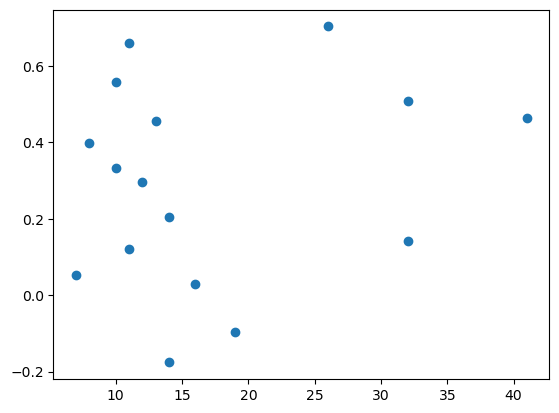

In [27]:
plt.scatter(x,cpe_y)

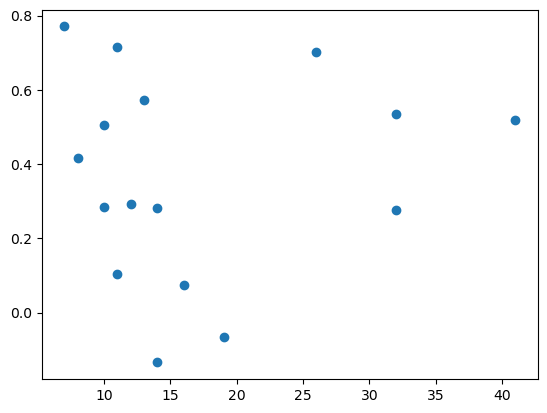

In [28]:
plt.scatter(x,regret_betas)

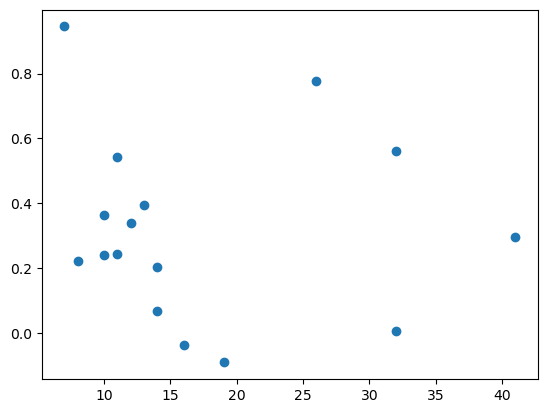

In [29]:
plt.scatter(x,relief_betas)

In [49]:
dep_regret_betas = regret_fits[dep_subj].iloc[-1]
nodep_regret_betas = regret_fits[nodep_subj].iloc[-1]

dep_cpe_betas = cpe_fits[dep_subj].iloc[-1]
nodep_cpe_betas = cpe_fits[nodep_subj].iloc[-1]

dep_relief_betas = relief_fits[dep_subj].iloc[-1]
nodep_relief_betas = relief_fits[nodep_subj].iloc[-1]

dep_full_regret_betas = full_fits[dep_subj].iloc[-2]
nodep_full_regret_betas = full_fits[nodep_subj].iloc[-2]

dep_full_relief_betas = full_fits[dep_subj].iloc[-1]
nodep_full_relief_betas = full_fits[nodep_subj].iloc[-1]

dep_full_rpe_betas = full_fits[dep_subj].iloc[-3]
nodep_full_rpe_betas = full_fits[nodep_subj].iloc[-3]


In [51]:
import scipy.stats as stats
stats.ttest_ind(dep_regret_betas, nodep_regret_betas, equal_var=False)


Ttest_indResult(statistic=1.5575617992722262, pvalue=0.15388561122019223)

In [52]:
stats.ttest_ind(dep_cpe_betas, nodep_cpe_betas, equal_var=False)


Ttest_indResult(statistic=1.5829655195579526, pvalue=0.16671086739811794)

In [53]:
stats.ttest_ind(dep_relief_betas, nodep_relief_betas, equal_var=False)


Ttest_indResult(statistic=0.6703564414005991, pvalue=0.5358483697854808)

In [54]:
stats.ttest_ind(dep_full_regret_betas, nodep_full_regret_betas, equal_var=False)


Ttest_indResult(statistic=1.7635809149658515, pvalue=0.13909111111943553)

In [55]:
stats.ttest_ind(dep_full_relief_betas, nodep_full_relief_betas, equal_var=False)


Ttest_indResult(statistic=0.49911612140969286, pvalue=0.627913806335884)

In [56]:
stats.ttest_ind(dep_full_rpe_betas, nodep_full_rpe_betas, equal_var=False)


Ttest_indResult(statistic=-1.2570219972017556, pvalue=0.25774804788565026)

## Prospect Theory GLMs

1) Rutledge EV (CR+EV)
2) PT (Util_s+Util_g) *validate this is better than Rutledge EV (PT1)
3) RPE PT (Util_s+Util_g+RPE)
4) CPE PT (Util_s+Util_g+tCPE) *tCPE always now
5) CPE+RPE PT (Util_s+Util_g+RPE+tCPE) 
6) Regret PT (Util_s+Util_g+tRegret) *omit RPE if model 4 > model 5
7) Relief PT (Util_s+Util_g+tRelief) *omit RPE if model 4 > model 5
8) Regret/Relief PT (Util_s+Util_g+tRegret+tRelief) 

In [ ]:
pt1_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)"]
pt2_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
pt3_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","decisioncpe(t-1)","decisioncpe(t-2)","decisioncpe(t-3)"]
pt4_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
pt5_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","decisioncpe(t-1)","decisioncpe(t-2)","decisioncpe(t-3)"]
pt6_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","decisioncpe(t-1)","decisioncpe(t-2)","decisioncpe(t-3)"]
pt7_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","totalcpe(t-1)","totalcpe(t-2)","totalcpe(t-3)"]
pt8_vars = ["cr(t-1)","cr(t-2)","cr(t-3)","choice_ev(t-1)","choice_ev(t-2)","choice_ev(t-3)","rpe(t-1)","rpe(t-2)","rpe(t-3)","decisioncpe(t-1)","decisioncpe(t-2)","decisioncpe(t-3)"]


# Model Figures

In [ ]:
#model comparison fig
rutledge_bic1 = np.array(list(cf_results_dict['rutledge']['bics1'].values()))
total_cpe_bic1 = np.array(list(cf_results_dict['total_cpe']['bics1'].values()))
regret_bic1 = np.array(list(cf_results_dict['regret']['bics1'].values()))
relief_bic1 = np.array(list(cf_results_dict['relief']['bics1'].values()))
combo_bic1 = np.array(list(cf_results_dict['combo']['bics1'].values()))

In [ ]:
bar_data = pd.DataFrame(columns=['RPE','CPE','Regret','Relief','CPE Split'])
bar_data['RPE'] = rutledge_bic1
bar_data['CPE'] = total_cpe_bic1
bar_data['Regret'] = regret_bic1
bar_data['Relief'] = relief_bic1
bar_data['CPE Split'] = combo_bic1

In [ ]:
#magma,cubehelix,twilight
fig,ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='whitegrid',font='Arial') 
sns.barplot(data=bar_data, errorbar=('ci',50),order=['Relief','Regret','RPE','CPE'],saturation=0.8,palette='flare',capsize=0.05,errcolor='black',errwidth=1.5)#flare_r,flare,Reds,YlOrRd, rocket
ax.set_title('SWB Model Evaluation',weight='semibold',fontsize=18,y=1.025)
#ax.set_xlabel('SWB Models',weight='medium',fontsize=15)
ax.set_ylabel('Mean BIC Score',weight='medium',fontsize=15,x=0.025)
ax.tick_params(labelsize=12)




In [ ]:
mood_est = list(pd.DataFrame.mean(cf_results_dict['total_cpe']['mood_est'],axis=1))

(-1.25, 1.25)

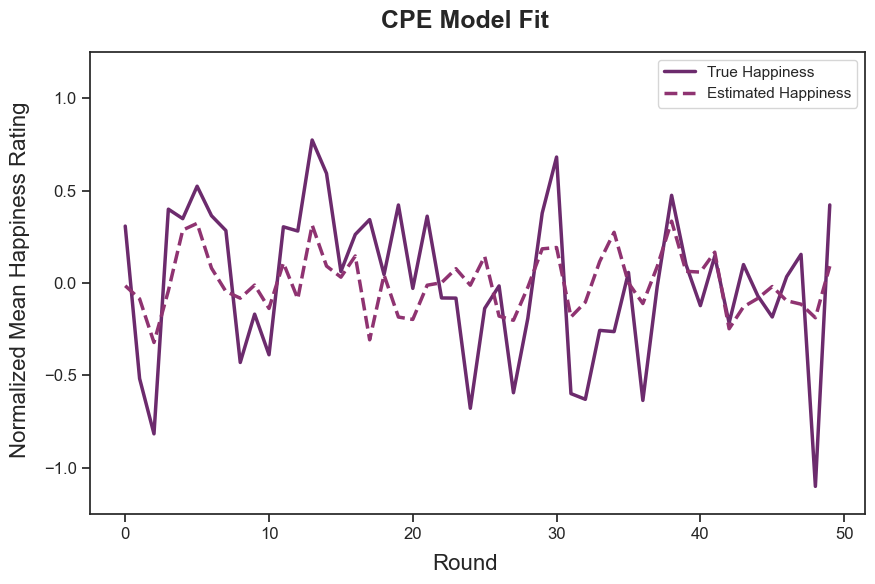

In [ ]:
fig,ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='ticks',font='Arial',palette='flare_r') 
sns.lineplot(x=np.arange(0,50), y=rate_means[:50],label='True Happiness',linewidth=2.5)
sns.lineplot(x=np.arange(0,50), y=mood_est[:50],label='Estimated Happiness',linestyle='dashed',linewidth=2.5)
fig.suptitle('CPE Model Fit',font='Arial',weight ='semibold',fontsize=18,y=0.95)
fig.supxlabel('Round',font='Arial',fontsize=16,y=0.01)
fig.supylabel('Normalized Mean Happiness Rating',font='Arial',fontsize=16,x=0.045)
ax.tick_params(labelsize=12)
ax.set_ylim(-1.25,1.25)



In [ ]:
lams = cf_results_dict['combo']['param_fits'].iloc[0]
b_cr = cf_results_dict['combo']['param_fits'].iloc[2]
b_ev = cf_results_dict['combo']['param_fits'].iloc[3]
b_reg = cf_results_dict['combo']['param_fits'].iloc[4]
b_rel = cf_results_dict['combo']['param_fits'].iloc[5]
l = np.mean(np.array(lams))
cr = np.mean(np.array(b_cr))
ev = np.mean(np.array(b_ev))
reg = np.mean(np.array(b_reg))
rel = np.mean(np.array(b_rel))
import itertools

weights_plot_df = pd.DataFrame(columns=['trial','Regressor','Weight_Estimate'])
weights_plot_df['trial'] = ['t1','t2','t3']*4
weights_plot_df['Regressor'] = list(itertools.chain.from_iterable([['Certain Reward']*3,['Expected Value']*3,['Regret']*3,['Relief']*3]))



#cr
cr_t1 = cr
cr_t2 = cr*l
cr_t3 = cr*(l**2)

#ev
ev_t1 = ev
ev_t2 = ev*l
ev_t3 = ev*(l**2)

#reg
reg_t1 = reg
reg_t2 = reg*l
reg_t3 = reg*(l**2)

#rel
rel_t1 = rel
rel_t2 = rel*l
rel_t3 = rel*(l**2)

weights_plot_df['Weight_Estimate'] = [cr_t1,cr_t2,cr_t3,ev_t1,ev_t2,ev_t3,reg_t1,reg_t2,reg_t3,rel_t1,rel_t2,rel_t3]


In [ ]:
#weights plot
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(17,5),sharey=True)
sns.set_theme(style='white',font='Arial') 
ax3.tick_params(labelsize=12)
sns.barplot(ax=ax1,data=weights_plot_df[weights_plot_df['Regressor']== 'Regret'],x='trial',y='Weight_Estimate',palette='Reds_r')
sns.barplot(ax=ax2,data=weights_plot_df[weights_plot_df['Regressor']== 'Relief'],x='trial',y='Weight_Estimate',palette='ocean_r')
sns.barplot(ax=ax3,data=weights_plot_df[weights_plot_df['Regressor']== 'Expected Value'],x='trial',y='Weight_Estimate',palette='YlGn_r')
sns.barplot(ax=ax4,data=weights_plot_df[weights_plot_df['Regressor']== 'Certain Reward'],x='trial',y='Weight_Estimate',palette='Purples_r')
ax1.set_ylim(0,0.65)
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('Regret',weight='medium',fontsize=14,y=1.02)

ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.tick_params(labelsize=12)
ax2.set_title('Relief',weight='medium',fontsize=14,y=1.02)

ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.tick_params(labelsize=12)
ax3.set_title('Expected Value',weight='medium',fontsize=14,y=1.02)

ax4.set_ylabel(None)
ax4.set_xlabel(None)
ax4.tick_params(labelsize=12)
ax4.set_title('Certain Reward',weight='medium',fontsize=14,y=1.02)

fig.suptitle('Model Estimates of Regressor Weights',weight='semibold',fontsize=18, y=1.025)
fig.supxlabel('Count of Trials Preceeding Happiness Rating',weight='medium',fontsize=16,y=0.01)
fig.supylabel('Weight Estimate',weight='medium',fontsize=16,x=0.085)




In [ ]:
#weights plot
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5),sharey=True)
sns.set_theme(style='white',font='Arial') 
ax3.tick_params(labelsize=12)
sns.barplot(ax=ax1,data=weights_plot_df[weights_plot_df['Regressor']== 'Regret'],x='trial',y='Weight_Estimate',palette='flare_r')
sns.barplot(ax=ax2,data=weights_plot_df[weights_plot_df['Regressor']== 'Relief'],x='trial',y='Weight_Estimate',palette='BuGn_r')

ax1.set_ylim(0,0.65)
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('Regret',weight='medium',fontsize=14,y=1.02)

ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.tick_params(labelsize=12)
ax2.set_title('Relief',weight='medium',fontsize=14,y=1.02)

fig.suptitle('Weight of Counterfactual Prediction Errors on Happiness Ratings',weight='semibold',fontsize=18, y=1.025)
fig.supxlabel('Count of Trials Preceeding Happiness Rating',weight='medium',fontsize=16)
fig.supylabel('Weight Estimate',weight='medium',fontsize=16,x=0.05)




In [ ]:
fig,ax = plt.subplots(1,4,figsize=(10,6))
sns.set_theme(style='whitegrid',font='Arial') 
sns.barplot(data=bar_data, errorbar=('ci',50),order=['CPE Split','Relief','Regret','RPE','CPE'],saturation=0.8,palette='flare',capsize=0.05,errcolor='black',errwidth=1.5)#flare_r,flare,Reds,YlOrRd, rocket
ax.set_title('SWB Model Evaluation',weight='semibold',fontsize=18,y=1.025)
#ax.set_xlabel('SWB Models',weight='medium',fontsize=15)
ax.set_ylabel('Mean BIC Score',weight='medium',fontsize=15,x=0.025)
ax.tick_params(labelsize=12)


In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(12,5))
sns.set_theme(style='ticks',font='Arial',palette='mako_r') #magma_r,gnuplot,paired,cubehelix_r
sns.regplot(data=gamble_plot,ax=ax1,x='loss_x',y='loss_y',ci=68,logistic=True,scatter=False)
sns.regplot(data=gamble_plot,ax=ax2,x='mix_x',y='mix_y',ci=68,logistic=True,scatter=False)
sns.regplot(data=gamble_plot,ax=ax3,x='gain_x',y='gain_y',ci=68,logistic=True,scatter=False)
ax1.set_ylim(0,1)
ax1.set_ylabel(None)
ax1.set_xlabel(None)
ax1.tick_params(labelsize=12)
ax1.set_title('Loss Trials',weight='medium',fontsize=15,y=1.02)
ax2.set_ylim(0,1)
ax2.set_ylabel(None)
ax2.set_xlabel(None)
ax2.tick_params(labelsize=12)
ax2.set_title('Mix Trials',weight='medium',fontsize=15,y=1.02)
ax3.set_ylim(0,1)
ax3.set_ylabel(None)
ax3.set_xlabel(None)
ax3.tick_params(labelsize=12)
ax3.set_title('Gain Trials',weight='medium',fontsize=15,y=1.02)
fig.supxlabel('Normalized Expected Value',y=-0.025,weight='medium',fontsize=16)
fig.supylabel('Proportion of Gamble Choices',x=0.05,weight='medium',fontsize=16)
fig.suptitle('Influence of Expected Value on Gamble Decision',y=1.05,weight='semibold',fontsize=18)

References:
- https://shawnrhoads.github.io/gu-psyc-347/module-02-01_Nonlinear-Modeling.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html
- https://hernandis.me/2020/04/05/three-examples-of-nonlinear-least-squares-fitting-in-python-with-scipy.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult
- https://www.nedcharles.com/regression/Nonlinear_Least_Squares_Regression_For_Python.html
